<a href="https://colab.research.google.com/github/DmitriyKhodykin/USFinancials/blob/main/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ПРОЕКТ: US Financials

Пакет для обработки сырых данных и получения датасета

## Пространство имен

In [ ]:
!pip install yahoo_fin requests_html

In [ ]:
# Импортры

## ОС и файлы
import os
import zipfile
import json
import warnings

## Постоянное хранилище данных
from google.colab import drive

## Время и дата
import datetime

## Таблицы и вычисления
import numpy as np
import pandas as pd

## Информация о рынке ценных бумаг
import yahoo_fin.stock_info as si
from yahoo_fin.stock_info import get_data
from yahoo_fin.stock_info import get_analysts_info

## Визуализация данных
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

In [ ]:
# Хранение и загрузка данных
drive.mount('/content/drive')
work_dir = '/content/drive/My Drive/Models/USFinancials'
data_dir = '/content/drive/My Drive/Data/USFinancials'

## Часто используемый код

In [ ]:
def tickers_checker(df_addr: pd.DataFrame, branch: str,
                    sheet: str, per: str, feature: str) -> list:
    """Подсчитывает количество наборов данных,
    в которых существуют данные по указанному признаку - feature
    branch - ветка данных (отчетность, доходность)
    sheet - набор показателей
    per - периодичность данных (quarterly, year)
    """
    tickers: list = []
  
    for indx, row in df_addr.iterrows():
        try:
            with open(row['addr'], "r") as content:
                tmp_dict = json.load(content)

            df: pd.DataFrame = pd.DataFrame(
                tmp_dict[branch][sheet][per]
            ).T
            
            # Преобрразование столбца фичей к "дата-время"
            df[feature] = pd.to_datetime(df[feature])

            # Проверка, что есть хотя бы одна дата в признаке
            if type(df[feature].max()) == pd._libs.tslibs.timestamps.Timestamp:
                tickers.append(row['ticker'])

        except (TypeError, KeyError, UnicodeDecodeError):
            pass

    return tickers

In [ ]:
def show_plot(data: pd.DataFrame, ticker: str):
    """Возвращает график по тикеру
    """
    data=data[data['ticker'] == ticker]
    sns.set(
        style="white",
        palette="muted",
        color_codes=True
    )
    sns.lineplot(
        x="date",
        y="adjclose",
        data=data[['date', 'adjclose']]
    ).set_title(ticker)
  
    return sns.despine(trim=False)

In [ ]:
def show_plots(data: pd.DataFrame, tickers_list: list, 
                nrows=5, ncols=3, figsize=(2, 5)):
    """Возвращает несколько графиков на фигуре
    размерностью (nrows*k x ncols*k) по списку
    тикеров [tickers_list]"""
    # Стиль графиков
    sns.set(
        style="white",
        palette="muted",
        color_codes=True
    )
    # Создание экземпляра фигуры и ее параметры
    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=figsize,
        constrained_layout=True
    )
    # Количество тикеров / размерность фигуры
    n_tickers = int(nrows) * int(ncols)
    # Список требуемых тикеров
    ord_tickers = tickers_list[:n_tickers]
    # Преобразование многомерного массива nparray в одномерный
    axs = axs.ravel()
    # Перебор в цикле участков фигуры
    for i in range(n_tickers):
        axs[i].plot(
            data[data['ticker'] == ord_tickers[i]]['date'],
            data[data['ticker'] == ord_tickers[i]]['adjclose']
        )
        # Заголовки участков фигуры
        axs[i].set_title(ord_tickers[i])
    
    return plt.show()

In [ ]:
def show_filing_period(df: pd.DataFrame, feature: str):
    """Распределение отклонений по выпуску отчетности
    """
    df_copy = df.copy()
    df_copy = df_copy[df_copy[feature] >= df_copy[feature].min()]
    df_copy['filing_days'] = df_copy[feature] - df_copy['date']
    df_copy['filing_days'] = df_copy['filing_days'].dt.days
    sns.set_theme()
    warnings.filterwarnings('ignore')
    return sns.distplot(df_copy[df_copy['filing_days'] < 100]['filing_days'])

## Подготовка данных

In [ ]:
# Посмотрим содержимое папки с данными
for root, dirs, files in os.walk(data_dir):
    print(files)

['US_Financials.zip']
[]
['._.DS_Store', '._AACQ.json']


In [ ]:
# Распакуем архив
z = zipfile.ZipFile(f'{data_dir}/US_Financials.zip', 'r')
z.extractall(data_dir)

In [ ]:
# Посмотрим на полученные каталоги папки с данными
for root, dirs, files in os.walk(data_dir):
    print(root)

/content/drive/My Drive/Data/USFinancials
/content/drive/My Drive/Data/USFinancials/US_Financials
/content/drive/My Drive/Data/USFinancials/__MACOSX
/content/drive/My Drive/Data/USFinancials/__MACOSX/US_Financials


In [ ]:
def get_flat_frame(data_dir: str) -> pd.DataFrame:
    """Возвращает датасет с путями до файлов
    в папке (неразмеченные данные).
    """
        
    files = []
    for i in os.listdir(data_dir):
        files.append([data_dir+'/'+i])
  
    df = pd.DataFrame(files, columns=['addr'], index=None)
    df['ticker'] = df['addr'].apply(lambda x: x[56:-5])

    return df

In [ ]:
# Соберем адреса файлов в таблицу для итерирования
files_addreses = get_flat_frame(f'{data_dir}/US_Financials')
files_addreses.head()

,addr,ticker
0,/content/drive/My Drive/Data/USFinancials/US_F...,AFGYF
1,/content/drive/My Drive/Data/USFinancials/US_F...,HLLGY
2,/content/drive/My Drive/Data/USFinancials/US_F...,UPNRF
3,/content/drive/My Drive/Data/USFinancials/US_F...,GEAGF
4,/content/drive/My Drive/Data/USFinancials/US_F...,OBNNF


In [ ]:
# Пример адреса файла
num_file = 150
tmp_dir = files_addreses['addr'][num_file]
ticker = files_addreses['ticker'][num_file]
print(tmp_dir)

/content/drive/My Drive/Data/USFinancials/US_Financials/TNAV.json


In [ ]:
print('Количество файлов:', len(files_addreses))

Количество файлов: 20866


In [ ]:
# Преобразование примера файла в словарь
with open(tmp_dir, "r") as content:
    tmp_dict = json.load(content)

In [ ]:
tmp_dict['General']['Name']

'Telenav, Inc'

### S&P500

In [ ]:
# Получим данные по S&P500

sandp500 = get_data(
    '^GSPC', 
    start_date = '2010-01-01',
    index_as_date = False,
    interval = '1d'
)

sandp500['ticker'] = '^GSPC'
sandp500['date'] = pd.to_datetime(sandp500['date'])
sandp500.head()

,date,open,high,low,close,adjclose,volume,ticker
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,^GSPC
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,^GSPC
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,^GSPC
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,^GSPC
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,^GSPC


In [ ]:
sandp500.index = sandp500['date']

In [ ]:
sandp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2825 entries, 2010-01-04 to 2021-03-24
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2825 non-null   datetime64[ns]
 1   open      2825 non-null   float64       
 2   high      2825 non-null   float64       
 3   low       2825 non-null   float64       
 4   close     2825 non-null   float64       
 5   adjclose  2825 non-null   float64       
 6   volume    2825 non-null   int64         
 7   ticker    2825 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 198.6+ KB


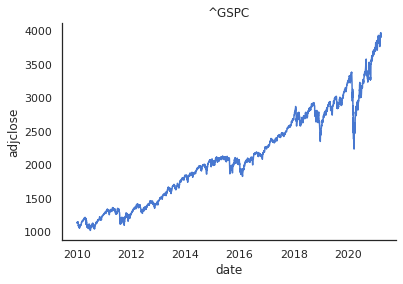

In [ ]:
show_plot(sandp500, '^GSPC')

### Stock

In [ ]:
# Котировки акций, очищенные от рынного шума (SNP500)
stock = pd.read_parquet(f'{work_dir}/US_stocks_hist_data.parquet')

In [ ]:
stock.tail()

ticker,A,AA,AAALF,AAALY,AABB,AABVF,AACAF,AACAY,AACG,AACQ,AACQU,AACQW,AACS,AACTF,AAEEF,AAGC,AAGEF,AAGFF,AAGH,AAGIY,AAGRY,AAIC,AAIGF,AAIIQ,AALBF,AAMAF,AAMC,AAME,AAMMF,AAMTF,AAN,AANNF,AAOI,AAON,AAP,AAPJ,AAPL,AAPT,AASL,AASP,...,ZPTAF,ZRSEF,ZRVT,ZS,ZSAN,ZSHGY,ZSTN,ZSYC,ZTCOF,ZTCOY,ZTLLF,ZTMUF,ZTNO,ZTO,ZTS,ZTSTF,ZULU,ZUMRF,ZUMZ,ZUO,ZURVY,ZVLO,ZVO,ZVTK,ZVZZT,ZWBC,ZWRKU,ZWZZT,ZXAIY,ZXZZT,ZYJT,ZYME,ZYNE,ZYQG,ZYRX,ZYXI,ZZHGF,ZZLL,ZZZOF,^GSPC
2021-03-16,0.993185,0.952601,1.001570,1.001570,1.256182,0.904795,1.001570,0.992512,0.915733,0.988350,0.980664,NaN,0.910661,0.971358,1.001570,1.130602,1.001570,0.988446,0.953951,0.970235,0.881049,0.952158,0.974543,1.001570,1.001570,1.001570,0.999016,1.006276,0.953040,1.080576,1.014023,1.001570,0.986083,0.974236,0.987370,1.001570,1.014313,0.858713,1.001570,1.001570,...,0.910661,1.001570,0.668681,0.990228,0.951570,1.001570,1.001570,1.001570,1.040632,0.993936,1.016645,1.001570,1.072998,0.997928,1.002797,0.934634,1.001570,1.001570,0.984355,0.998800,0.996876,0.837635,0.963639,0.868236,NaN,1.001570,1.000779,1.001570,0.855228,NaN,1.001570,0.991915,0.729877,1.001570,1.001570,0.986260,1.001570,1.001570,1.681570,1.0
2021-03-17,0.993218,1.074695,0.997121,0.997121,1.114768,0.997121,0.997121,1.011746,1.076933,0.987551,0.998900,NaN,0.797121,1.025158,0.997121,0.939978,0.997121,1.044993,1.097121,1.006106,0.997121,1.021873,1.006644,0.997121,0.866093,0.997121,0.969471,0.994779,0.997121,0.997121,0.989264,0.997121,0.982514,0.991774,1.013033,1.004867,0.990670,0.997121,0.977121,0.957386,...,1.057121,0.997121,1.297121,1.014411,1.102384,0.997121,0.941327,0.997121,0.997121,1.074044,0.997121,0.954867,0.997121,1.001690,1.004474,0.997121,0.950609,0.997121,1.009921,1.024898,1.002780,2.879474,0.986368,0.940967,NaN,0.997121,0.996132,0.997121,0.997121,NaN,0.282835,0.970533,1.051808,0.997121,0.997121,1.010802,0.997121,0.997121,0.596327,1.0
2021-03-18,1.015332,0.995270,1.014761,1.014761,1.067129,0.871903,1.014761,0.994941,1.045195,1.015727,1.008544,NaN,1.264761,0.969306,1.014761,1.105670,1.014761,1.010953,1.014761,1.013177,1.014761,0.990606,1.010830,1.014761,1.014761,0.923851,1.036351,1.080488,1.016306,1.014339,0.997415,1.014761,0.969150,1.018757,1.025877,1.258646,0.980855,0.848094,1.014761,1.014761,...,0.920421,0.716208,1.013991,0.976343,0.946733,1.014761,1.014761,1.014761,1.011001,0.977261,0.922351,1.014761,1.014761,0.908636,0.990748,1.014761,1.014761,1.014761,1.009217,1.007328,1.009368,1.014761,1.023819,1.176130,NaN,1.014761,1.013770,1.014761,0.871903,NaN,1.014761,0.981377,0.909205,1.014761,1.014761,0.964454,1.014761,1.014761,1.339264,1.0
2021-03-19,0.999241,0.995925,0.997528,0.997528,1.155067,0.946694,0.997528,0.996149,1.113562,0.992702,0.990379,NaN,1.147528,0.991179,0.997528,1.319750,0.997528,1.007464,0.973959,1.005258,0.997528,0.977726,0.980164,0.544451,0.997528,1.013153,0.901136,1.253034,1.046910,1.083501,0.989853,0.997528,1.010670,0.990527,1.009883,0.991910,0.993048,0.997528,0.997528,0.790631,...,1.060028,1.013968,0.997528,1.016326,1.034024,0.997528,1.088437,0.997528,1.018282,0.997528,0.997528,0.997528,0.997528,0.968016,1.002120,0.997528,0.997528,0.997528,1.030750,1.025438,1.004128,0.412494,1.051388,0.936651,NaN,0.997528,0.988608,0.997528,0.997528,NaN,0.997528,1.096429,1.096907,0.997528,1.747528,1.037580,0.997528,0.997528,0.997528,1.0
2021-03-20,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.

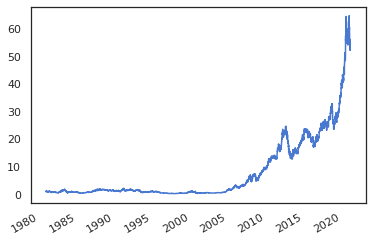

In [ ]:
stock['AAPL'].cumprod().plot();

### Фин. показатели

`filing_date` - Ключевой показатель, т.к. позволяет установить временной период между подачей отчетности эмитентом и изменением поведения акции на рынке. Для начала целесообразно отсечь ту отчетность, в которой показатель отсутствует

In [ ]:
# Ключ финансового состояния эмитента
tmp_dict['Financials'].keys()

dict_keys(['Balance_Sheet', 'Cash_Flow', 'Income_Statement'])

#### Balance Sheet (Баланс)

In [ ]:
# Пример датафрейма c балансовыми показателями

balance_sheet: pd.DataFrame = pd.DataFrame(
    tmp_dict['Financials']
            ['Balance_Sheet']
            ['quarterly']
).T  # Транспонирование датафрейма

balance_sheet['Name'] = ticker
balance_sheet['filing_date'] = pd.to_datetime(balance_sheet['filing_date'])
balance_sheet['date'] = pd.to_datetime(balance_sheet['date'])

balance_sheet.head(5)

,date,filing_date,currency_symbol,totalAssets,intangibleAssets,earningAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,otherCurrentLiab,commonStock,retainedEarnings,otherLiab,goodWill,otherAssets,cash,totalCurrentLiabilities,shortTermDebt,shortLongTermDebt,shortLongTermDebtTotal,otherStockholderEquity,propertyPlantEquipment,totalCurrentAssets,longTermInvestments,netTangibleAssets,shortTermInvestments,netReceivables,longTermDebt,inventory,accountsPayable,totalPermanentEquity,noncontrollingInterestInConsolidatedEntity,temporaryEquityRedeemableNoncontrollingInterests,accumulatedOtherComprehensiveIncome,additionalPaidInCapital,commonStockTotalEquity,preferredStockTotalEquity,retainedEarningsTotalEquity,treasuryStock,accumulatedAmortization,nonCurrrentAssetsOther,deferredLongTermAssetCharges,nonCurrentAssetsTotal,capitalLeaseObligations,longTermDebtTotal,nonCurrentLiabilitiesOther,nonCurrentLiabilitiesTotal,negativeGoodwill,warrants,preferredStockRedeemable,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,propertyPlantAndEquipmentGross,accumulatedDepreciation,commonStockSharesOutstanding,Name
2020-08-31,2020-08-31,2020-12-04,USD,9811000000.00,None,None,902000000.00,7833000000.00,252000000.00,None,1388000000.00,3190000000.00,-2863000000.00,671000000.00,249000000.00,381000000.00,889000000.00,4394000000.00,699000000.00,699000000.00,None,-75000000.00,3770000000.00,3907000000.00,None,1729000000.00,None,256000000.00,3266000000.00,1860000000.00,2307000000.00,None,None,None,None,None,3190000000.00,None,-2863000000.00,None,None,1885000000.00,None,5904000000.00,1995000000.00,2767000000.00,672000000.00,3439000000.00,None,None,None,None,9811000000.00,889000000.00,None,6987000000.00,157700000.00,JWN
2020-06-30,2020-06-30,NaT,USD,9535000000.00,None,None,None,9361000000.00,174000000.00,None,1284000000.00,3168000000.00,-2916000000.00,671000000.00,249000000.00,381000000.00,991000000.00,3642000000.00,None,500000000.00,None,-78000000.00,5500000000.00,3405000000.00,None,-75000000.00,None,146000000.00,3266000000.00,1466000000.00,1298000000.00,None,None,None,None,None,None,None,None,None,None,381000000.00,None,6130000000.00,2054000000.00,None,671000000.00,5719000000.00,None,None,None,None,None,None,None,None,None,JWN
2020-05-31,2020-05-31,2020-06-10,USD,9969000000.00,None,None,669000000.00,7736000000.00,397000000.00,None,1594000000.00,3148000000.00,-2661000000.00,673000000.00,249000000.00,357000000.00,1355000000.00,3799000000.00,800000000.00,800000000.00,None,-90000000.00,3974000000.00,3667000000.00,None,1984000000.00,None,154000000.00,3264000000.00,1489000000.00,1405000000.00,None,None,None,None,None,3148000000.00,None,-2661000000.00,None,None,2079000000.00,None,6302000000.00,2079000000.00,3264000000.00,673000000.00,3937000000.00,None,None,None,None,9969000000.00,1355000000.00,None,None,157000000.00,JWN
2020-03-31,2020-03-31,NaT,USD,9969000000.00,None,None,None,9572000000.00,397000000.00,None,1351000000.00,3148000000.00,-2661000000.00,673000000.00,249000000.00,357000000.00,1355000000.00,3799000000.00,None,800000000.00,None,-90000000.00,5696000000.00,3667000000.00,None,148000000.00,None,154000000.00,3264000000.00,1489000000.00,1125000000.00,None,None,None,None,None,None,None,None,None,None,357000000.00,None,6302000000.00,2079000000.00,None,673000000.00,5773000000.00,None,None,None,None,None,None,None,None,None,JWN
2020-02-29,2020-02-29,2020-03-20,USD,9737000000.00,None,None,278000000.00,6883000000.00,979000000.00,4000000.00,1434000000.00,3129000000.00,-2082000000.00,687000000.00,249000000.00,305000000.00,853000000.00,3520000000.00,None,800000000.00,None,-68000000.00,4179000000.00,3230000000.00,None,2605000000.00,None,179000000.00,3264000000.00,1920000000.00,2086000000.00,None,None,None,None,None,3129000000.00,None,-2082000000.00,None,None,2079000000.00,None,6507000000.00,2079000000.00,2676000000.00,683000000.00,3363000000.00,None,None,None,None,9737000000.00,853000000.00,None,None,155600000.00,J

In [ ]:
type(balance_sheet['filing_date'].max()) == pd._libs.tslibs.timestamps.Timestamp

True

In [ ]:
balance_sheet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 2020-12-31 to 2008-06-30
Data columns (total 58 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   date                                              48 non-null     datetime64[ns]
 1   filing_date                                       37 non-null     datetime64[ns]
 2   currency_symbol                                   48 non-null     object        
 3   totalAssets                                       46 non-null     object        
 4   intangibleAssets                                  37 non-null     object        
 5   earningAssets                                     0 non-null      object        
 6   otherCurrentAssets                                46 non-null     object        
 7   totalLiab                                         46 non-null     object        
 8   totalStockholderEqui

In [ ]:
# Проверим, по каким тикерам есть хотя бы частично заполненные `filing_date`
bs_tickers = tickers_checker(files_addreses, 'Financials', 'Balance_Sheet',
                            'quarterly', 'filing_date')

In [ ]:
print('В выборку по Балансу попало:', len(bs_tickers), 'тикеров эмитентов')
print(bs_tickers)

В выборку по Балансу попало: 4200 тикеров эмитентов
['VIVE', 'CVGI', 'SRLP', 'JWN', 'IIIN', 'TYME', 'SCCO', 'CDTX', 'OGE', 'NOV', 'MYFW', 'SENEB', 'MGEN', 'HGSH', 'PZZA', 'CELC', 'PATK', 'MRLN', 'OUT', 'CLNY', 'BRN', 'USM', 'MOSY', 'PRPH', 'TNAV', 'KLDO', 'RCMT', 'VAL', 'TITN', 'HRTG', 'SLNO', 'ACRE', 'AGLE', 'NXTD', 'PSMT', 'DTE', 'REGI', 'AMPH', 'COR', 'PIH', 'KE', 'LACQ', 'FNWB', 'ALTM', 'OBLN', 'KIM', 'BATRA', 'NFG', 'PCYO', 'ILPT', 'IPGP', 'GS', 'EVTN', 'PNBK', 'IGXT', 'ULBI', 'RVSB', 'GOSS', 'NSPR', 'SCTY', 'AAOI', 'ENG', 'USWSW', 'GRBK', 'REYN', 'CSL', 'MVBF', 'SIX', 'TCMD', 'SMTX', 'UNMA', 'VSH', 'BA', 'PFSW', 'TEL', 'HPQ', 'POST', 'FZMD', 'ITT', 'ATOM', 'MSM', 'NOC', 'PNC', 'HALO', 'FMBH', 'UTGN', 'NYMTM', 'MOS', 'CTG', 'APVS', 'MTSI', 'ABC', 'XSPA', 'QADB', 'ALL', 'USX', 'SRCL', 'TTEC', 'PGR', 'ALTX', 'CAH', 'PFTI', 'FNB', 'LHCG', 'WIRE', 'CARV', 'CPLG', 'CSPI', 'ALXN', 'PKD', 'DTP', 'UNFI', 'DCOMP', 'TRCH', 'COG', 'HOPE', 'PDLB', 'TPC', 'ITRM', 'LUNA', 'SKT', 'INTT', 'LEVL',

In [ ]:
# Сохраним список тикеров
bs_tickers = pd.DataFrame(bs_tickers, columns=['tickers'])
bs_tickers.to_csv(f'{data_dir}/bs_tickers.csv')

In [ ]:
# Получим данные об adj.close по тикеру

tnav = get_data(
    ticker, 
    start_date = '2010-01-01',
    index_as_date = False,
    interval = '1d'
)

tnav['ticker'] = ticker
tnav['date'] = pd.to_datetime(tnav['date'])
tnav.head()

,date,open,high,low,close,adjclose,volume,ticker
0,2010-05-13,9.00,11.48,8.86,9.80,9.80,2349495.0,TNAV
1,2010-05-14,10.30,10.30,8.95,9.20,9.20,605755.0,TNAV
2,2010-05-17,9.47,9.47,8.74,8.99,8.99,243888.0,TNAV
3,2010-05-18,9.01,9.23,8.07,8.40,8.40,227780.0,TNAV
4,2010-05-19,8.55,8.65,8.24,8.43,8.43,90274.0,TNAV


In [ ]:
tnav.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2734 entries, 0 to 2733
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2734 non-null   datetime64[ns]
 1   open      2710 non-null   float64       
 2   high      2710 non-null   float64       
 3   low       2710 non-null   float64       
 4   close     2710 non-null   float64       
 5   adjclose  2710 non-null   float64       
 6   volume    2710 non-null   float64       
 7   ticker    2734 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 171.0+ KB


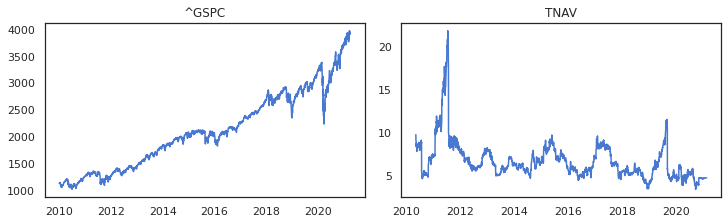

In [ ]:
show_plots(pd.concat([sandp500, tnav]), 
           ['^GSPC', 'TNAV'], 
           nrows=1, ncols=2, figsize=(10, 3))

Альтернативное заполнение `filling_date`

In [ ]:
def alter_filing(period: pd._libs.tslibs.timestamps):
    """Возвращает предполагаемую дату filling_date
    period - Период отчетности (из фин.показателей)
    df - Датафрейм с динамикой курса акции
    """
    # Определение анализируемого периода
    start_filing = period + datetime.timedelta(40)
    end_filing = period + datetime.timedelta(80)
    # Фильтр df по временному периоду подачи отчетности
    filtred_df = tnav[(tnav['date'] >= start_filing) &
                      (tnav['date'] <= end_filing)]
    # Метод первых разниц для определения динамики ряда
    try:
        filtred_df['diff'] = abs(filtred_df['adjclose'].diff(periods=1))
        # Поиск максимального изменения курса (по модулю)
        dt = filtred_df[filtred_df['diff'] == filtred_df['diff']\
                        .max()]['date'].values[0]
        dt = pd.to_datetime(dt)
    except (IndexError, TypeError):
        dt = 'Нет данных'

    return dt

In [ ]:
# Столбец с альтернативной датой подачи финансовой отчетности эмитента
balance_sheet['alter_filing'] = balance_sheet['date'].apply(alter_filing)

In [ ]:
tmp_bs = balance_sheet[balance_sheet['filing_date'] > 
                       balance_sheet['filing_date'].min()]
tmp_bs['alter_filing'] = pd.to_datetime(tmp_bs['alter_filing'])
tmp_bs['M'] = abs(tmp_bs['alter_filing'] - tmp_bs['filing_date'])

In [ ]:
# MAE ошибки альтернативного заполнения периода
tmp_bs['M'].mean()

Timedelta('20 days 22:00:00')

In [ ]:
tmp_bs[['filing_date', 'alter_filing', 'M']].head()

,filing_date,alter_filing,M
2020-12-31,2021-02-05,2021-02-10,5 days
2020-09-30,2020-11-05,2020-12-03,28 days
2020-06-30,2020-08-21,2020-08-18,3 days
2020-03-31,2020-05-08,2020-06-11,34 days
2019-12-31,2020-02-13,2020-03-18,34 days


#### Cash Flow (Денежный Поток)

Повторим аналогичные действия для денежного потока - `cf (cash_flow)`

In [ ]:
cash_flow: pd.DataFrame = pd.DataFrame(
    tmp_dict['Financials']
            ['Cash_Flow']
            ['quarterly']
).T  # Транспонирование датафрейма

cash_flow['Name'] = ticker

cash_flow.head(10)

,date,filing_date,currency_symbol,investments,changeToLiabilities,totalCashflowsFromInvestingActivities,netBorrowings,totalCashFromFinancingActivities,changeToOperatingActivities,netIncome,changeInCash,beginPeriodCashFlow,endPeriodCashFlow,totalCashFromOperatingActivities,depreciation,otherCashflowsFromInvestingActivities,dividendsPaid,changeToInventory,changeToAccountReceivables,salePurchaseOfStock,otherCashflowsFromFinancingActivities,changeToNetincome,capitalExpenditures,changeReceivables,cashFlowsOtherOperating,exchangeRateChanges,cashAndCashEquivalentsChanges,Name
2020-12-31,2020-12-31,2021-02-05,USD,-6138000.00,5674000.00,-6226000.00,None,-755000.00,1587000.00,-60000.00,7974000.00,30372000.00,38791000.00,14955000.00,751000.00,None,None,None,3493000.00,0.00,-755000.00,1275000.00,88000,3493000.00,3762000.00,None,7974000.00,TNAV
2020-09-30,2020-09-30,2020-11-05,USD,13699000.00,-3262000.00,13632000.00,None,-718000.00,-655000.00,3335000.00,7906000.00,22012000.00,30372000.00,-5008000.00,845000.00,None,None,None,-12653000.00,-359000.00,-359000.00,2135000.00,67000,-12653000.00,7927000.00,None,7906000.00,TNAV
2020-06-30,2020-06-30,None,USD,18365000.00,-16508000.00,18365000.00,None,-62000.00,-226000.00,-9249000.00,3995000.00,18017000.00,22012000.00,-14410000.00,1590000.00,None,None,None,7364000.00,0.00,None,2441000.00,0,None,None,None,None,TNAV
2020-03-31,2020-03-31,None,USD,-11428000.00,22272000.00,-11428000.00,None,-5332000.00,-14442000.00,-733000.00,-9850000.00,27867000.00,30372000.00,7168000.00,1661000.00,-45058000.00,None,None,2499000.00,-5334000.00,-1636000.00,-3707000.00,242000,None,None,None,None,TNAV
2019-12-31,2019-12-31,2020-02-13,USD,-1506000.00,-5491000.00,-2123000.00,None,-4335000.00,5910000.00,15180000.00,5886000.00,21730000.00,27867000.00,12344000.00,997000.00,-33872000.00,None,None,9182000.00,-4019000.00,-316000.00,99000.00,617000,9182000.00,7557000.00,None,5886000.00,TNAV
2019-09-30,2019-09-30,None,USD,-32827000.00,14130000.00,-32827000.00,None,7474000.00,-9651000.00,-6128000.00,-3520000.00,20099000.00,None,22169000.00,1466000.00,-32366000.00,None,None,16653000.00,8306000.00,-832000.00,1876000.00,461000,None,None,None,None,TNAV
2019-06-30,2019-06-30,2019-08-22,USD,-5249000.00,38004000.00,-5691000.00,None,7346000.00,6539000.00,-12856000.00,6133000.00,None,None,4478000.00,983000.00,-2079000.00,None,None,-18006000.00,7497000.00,-151000.00,3104000.00,442000,-18006000.00,-6751000.00,None,6133000.00,TNAV
2019-03-31,2019-03-31,2019-05-10,USD,-1310000.00,25977000.00,-1821000.00,None,-245000.00,966000.00,-7481000.00,-1671000.00,20099000.00,None,395000.00,951000.00,3170000.00,None,None,-14223000.00,27000.00,-272000.00,1742000.00,511000,-14223000.00,-6571000.00,None,-1671000.00,TNAV
2018-12-31,2018-12-31,2019-02-08,USD,4239000.00,5739000.00,3893000.00,None,-351000.00,-10485000.00,-4208000.00,8476000.00,None,None,4934000.00,1001000.00,4480000.00,None,None,3358000.00,2000.00,-353000.00,2167000.00,346000,3358000.00,-3123000.00,None,8476000.00,TNAV
2018-09-30,2018-09-30,2018-11-09,USD,241000.00,7589000.00,141000.00,None,-1182000.00,-6092000.00,-7943000.00,-3334000.00,None,None,-2293000.00,1015000.00,0.00,0.00,0.00,-780000.00,24000.00,-1206000.00,2577000.00,100000,-780000.00,-4751000.00,None,-3334000.00,TNAV


In [ ]:
cash_flow.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 2020-12-31 to 2016-12-31
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   date                                   17 non-null     object
 1   filing_date                            0 non-null      object
 2   currency_symbol                        17 non-null     object
 3   investments                            14 non-null     object
 4   changeToLiabilities                    17 non-null     object
 5   totalCashflowsFromInvestingActivities  17 non-null     object
 6   netBorrowings                          17 non-null     object
 7   totalCashFromFinancingActivities       13 non-null     object
 8   changeToOperatingActivities            17 non-null     object
 9   netIncome                              16 non-null     object
 10  changeInCash                           13 non-null     object
 11  beginPeri

In [ ]:
cf_tickers = tickers_checker(files_addreses, 'Financials', 'Cash_Flow',
                            'quarterly', 'filing_date')

In [ ]:
print('В выборку по ДП попало:', len(cf_tickers), 'тикеров эмитентов')
print(cf_tickers)

В выборку по ДП попало: 4149 тикеров эмитентов
['VIVE', 'CVGI', 'SRLP', 'JWN', 'IIIN', 'TYME', 'SCCO', 'CDTX', 'OGE', 'NOV', 'MYFW', 'SENEB', 'MGEN', 'HGSH', 'PZZA', 'CELC', 'PATK', 'MRLN', 'OUT', 'CLNY', 'BRN', 'USM', 'MOSY', 'PRPH', 'TNAV', 'KLDO', 'RCMT', 'VAL', 'TITN', 'HRTG', 'SLNO', 'ACRE', 'AGLE', 'NXTD', 'PSMT', 'DTE', 'REGI', 'AMPH', 'COR', 'PIH', 'KE', 'LACQ', 'FNWB', 'ALTM', 'OBLN', 'KIM', 'BATRA', 'NFG', 'PCYO', 'ILPT', 'IPGP', 'GS', 'EVTN', 'PNBK', 'IGXT', 'ULBI', 'RVSB', 'GOSS', 'NSPR', 'SCTY', 'AAOI', 'ENG', 'USWSW', 'GRBK', 'CSL', 'MVBF', 'SIX', 'TCMD', 'SMTX', 'UNMA', 'VSH', 'BA', 'PFSW', 'TEL', 'HPQ', 'POST', 'FZMD', 'ITT', 'ATOM', 'MSM', 'NOC', 'PNC', 'HALO', 'FMBH', 'UTGN', 'NYMTM', 'MOS', 'CTG', 'APVS', 'MTSI', 'ABC', 'XSPA', 'QADB', 'ALL', 'USX', 'SRCL', 'TTEC', 'PGR', 'ALTX', 'CAH', 'PFTI', 'FNB', 'LHCG', 'WIRE', 'CARV', 'CPLG', 'CSPI', 'ALXN', 'PKD', 'DTP', 'UNFI', 'DCOMP', 'TRCH', 'COG', 'HOPE', 'PDLB', 'TPC', 'ITRM', 'LUNA', 'SKT', 'INTT', 'LEVL', 'MDLZ', 'DXC

In [ ]:
cf_tickers = pd.DataFrame(cf_tickers, columns=['tickers'])
cf_tickers.to_csv(f'{data_dir}/cf_tickers.csv')

#### Income Statement (Справка о доходах)

... и справки о доходах (is)

In [ ]:
income_statement: pd.DataFrame = pd.DataFrame(
    tmp_dict['Financials']
            ['Income_Statement']
            ['quarterly']
).T  # Транспонирование датафрейма

income_statement['Name'] = ticker

income_statement.head(10)

,date,filing_date,currency_symbol,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,netIncome,sellingGeneralAdministrative,grossProfit,ebit,nonOperatingIncomeNetOther,operatingIncome,otherOperatingExpenses,interestExpense,taxProvision,interestIncome,netInterestIncome,extraordinaryItems,nonRecurring,otherItems,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,preferredStockAndOtherAdjustments,Name
2020-12-31,2020-12-31,2021-02-05,USD,18528000.00,None,-1406000.00,None,-60000.00,11125000.00,27726000.00,-127000.00,1800000.00,-1927000.00,None,None,-67000.00,None,None,None,None,None,-67000.00,65854000.00,29653000.00,38128000.00,521000.00,None,-1339000.00,-60000.00,None,TNAV
2020-09-30,2020-09-30,2020-11-05,USD,18986000.00,None,2733000.00,None,3335000.00,8508000.00,29513000.00,3489000.00,1330000.00,2019000.00,None,None,14000.00,None,None,None,None,None,14000.00,69596000.00,27494000.00,40083000.00,714000.00,None,2719000.00,3335000.00,None,TNAV
2020-06-30,2020-06-30,2020-08-21,USD,17259000.00,None,-9216000.00,None,-9249000.00,7738000.00,15016000.00,-8391000.00,947000.00,-9981000.00,None,None,215000.00,None,None,None,None,None,215000.00,35351000.00,45332000.00,20335000.00,765000.00,None,-9249000.00,-9249000.00,None,TNAV
2020-03-31,2020-03-31,2020-05-08,USD,21617000.00,None,-125000.00,None,-733000.00,8569000.00,28973000.00,448000.00,985000.00,-1213000.00,None,None,505000.00,None,None,None,None,None,505000.00,64496000.00,30186000.00,35523000.00,1088000.00,None,-630000.00,-733000.00,None,TNAV
2019-12-31,2019-12-31,2020-02-13,USD,19717000.00,None,12470000.00,None,13006000.00,10176000.00,24985000.00,-2626000.00,1393000.00,11874000.00,None,None,205000.00,None,None,-56000.00,None,None,205000.00,57176000.00,28279000.00,32191000.00,596000.00,-56000.00,12265000.00,13006000.00,None,TNAV
2019-09-30,2019-09-30,None,USD,20663000.00,None,-1731000.00,None,-6128000.00,9865000.00,21064000.00,-7893000.00,None,-2292000.00,None,None,411000.00,None,None,-3986000.00,None,None,411000.00,52168000.00,66747000.00,31104000.00,561000.00,-3986000.00,-2142000.00,-3954000.00,None,TNAV
2019-06-30,2019-06-30,2019-08-22,USD,24252000.00,None,-12592000.00,None,-12856000.00,12304000.00,26357000.00,-6595000.00,213000.00,-10199000.00,None,None,264000.00,None,None,None,2606000.00,None,264000.00,58452000.00,68651000.00,32095000.00,-2393000.00,-3986000.00,-12856000.00,-12856000.00,None,TNAV
2019-03-31,2019-03-31,2019-05-10,USD,20508000.00,None,-7273000.00,None,-7481000.00,10788000.00,23442000.00,-6888000.00,581000.00,-7854000.00,None,None,194000.00,None,None,-1947000.00,None,None,208000.00,53069000.00,31296000.00,29627000.00,581000.00,-3986000.00,-7481000.00,-7481000.00,None,TNAV
2018-12-31,2018-12-31,2019-02-08,USD,19091000.00,None,-4400000.00,None,-4581000.00,10650000.00,16769000.00,-14927000.00,532000.00,-4932000.00,None,0.00,None,None,None,-463000.00,650000.00,None,181000.00,39080000.00,29917000.00,22311000.00,-118000.00,-3986000.00,-4581000.00,-4581000.00,None,TNAV
2018-09-30,2018-09-30,2018-11-09,USD,20102000.00,None,-7313000.00,None,-7943000.00,10275000.00,15811000.00,-14580000.00,1590000.00,-8903000.00,None,0.00,None,None,None,None,None,None,630000.00,36658000.00,29967000.00,20847000.00,1590000.00,None,-7943000.00,-7943000.00,None,TNAV


In [ ]:
income_statement.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 2020-12-31 to 2016-12-31
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   date                               17 non-null     object
 1   filing_date                        0 non-null      object
 2   currency_symbol                    17 non-null     object
 3   researchDevelopment                5 non-null      object
 4   effectOfAccountingCharges          5 non-null      object
 5   incomeBeforeTax                    16 non-null     object
 6   minorityInterest                   17 non-null     object
 7   netIncome                          16 non-null     object
 8   sellingGeneralAdministrative       16 non-null     object
 9   grossProfit                        16 non-null     object
 10  ebit                               16 non-null     object
 11  nonOperatingIncomeNetOther         4 non-null      object
 12

In [ ]:
is_tickers = tickers_checker(files_addreses, 'Financials', 'Income_Statement',
                            'quarterly', 'filing_date')

In [ ]:
print('В выборку по СоД попало:', len(is_tickers), 'тикеров эмитентов')
print(is_tickers)

В выборку по СоД попало: 4183 тикеров эмитентов
['VIVE', 'CVGI', 'SRLP', 'JWN', 'IIIN', 'TYME', 'SCCO', 'CDTX', 'OGE', 'NOV', 'MYFW', 'SENEB', 'MGEN', 'HGSH', 'PZZA', 'CELC', 'PATK', 'MRLN', 'OUT', 'CLNY', 'BRN', 'USM', 'MOSY', 'PRPH', 'TNAV', 'KLDO', 'RCMT', 'VAL', 'TITN', 'HRTG', 'SLNO', 'ACRE', 'AGLE', 'NXTD', 'PSMT', 'DTE', 'REGI', 'AMPH', 'COR', 'PIH', 'KE', 'LACQ', 'FNWB', 'ALTM', 'OBLN', 'KIM', 'BATRA', 'NFG', 'PCYO', 'ILPT', 'IPGP', 'GS', 'EVTN', 'PNBK', 'IGXT', 'ULBI', 'RVSB', 'GOSS', 'NSPR', 'SCTY', 'AAOI', 'ENG', 'USWSW', 'GRBK', 'CSL', 'MVBF', 'SIX', 'TCMD', 'SMTX', 'UNMA', 'VSH', 'BA', 'PFSW', 'TEL', 'HPQ', 'POST', 'FZMD', 'ITT', 'ATOM', 'MSM', 'NOC', 'PNC', 'HALO', 'FMBH', 'UTGN', 'NYMTM', 'MOS', 'CTG', 'APVS', 'MTSI', 'ABC', 'XSPA', 'QADB', 'ALL', 'USX', 'SRCL', 'TTEC', 'PGR', 'ALTX', 'CAH', 'PFTI', 'FNB', 'LHCG', 'WIRE', 'CARV', 'CPLG', 'CSPI', 'ALXN', 'PKD', 'DTP', 'UNFI', 'DCOMP', 'TRCH', 'COG', 'HOPE', 'PDLB', 'TPC', 'ITRM', 'LUNA', 'SKT', 'INTT', 'LEVL', 'MDLZ', 'DX

In [ ]:
is_tickers = pd.DataFrame(is_tickers, columns=['tickers'])
is_tickers.to_csv(f'{data_dir}/is_tickers.csv')

In [ ]:
def common_tickers(df1, df2, df3):

    common_tickers: list = []

    list_1 = df1['tickers'].values.tolist()
    list_2 = df2['tickers'].values.tolist()
    list_3 = df3['tickers'].values.tolist()

    for i in list_1:
        if i in list_2 and i in list_3:
            common_tickers.append(i)
    
    return common_tickers

In [ ]:
# Количество пересекающихся тикеров с частично заполненным fiiling_date
financials_common_tickers = common_tickers(bs_tickers,
                                           cf_tickers,
                                           is_tickers)

print('Количество тикеров с частично заполненными filling_date', 
      len(financials_common_tickers))

print(financials_common_tickers)

Количество тикеров с частично заполненными filling_date 4146
['VIVE', 'CVGI', 'SRLP', 'JWN', 'IIIN', 'TYME', 'SCCO', 'CDTX', 'OGE', 'NOV', 'MYFW', 'SENEB', 'MGEN', 'HGSH', 'PZZA', 'CELC', 'PATK', 'MRLN', 'OUT', 'CLNY', 'BRN', 'USM', 'MOSY', 'PRPH', 'TNAV', 'KLDO', 'RCMT', 'VAL', 'TITN', 'HRTG', 'SLNO', 'ACRE', 'AGLE', 'NXTD', 'PSMT', 'DTE', 'REGI', 'AMPH', 'COR', 'PIH', 'KE', 'LACQ', 'FNWB', 'ALTM', 'OBLN', 'KIM', 'BATRA', 'NFG', 'PCYO', 'ILPT', 'IPGP', 'GS', 'EVTN', 'PNBK', 'IGXT', 'ULBI', 'RVSB', 'GOSS', 'NSPR', 'SCTY', 'AAOI', 'ENG', 'USWSW', 'GRBK', 'CSL', 'MVBF', 'SIX', 'TCMD', 'SMTX', 'UNMA', 'VSH', 'BA', 'PFSW', 'TEL', 'HPQ', 'POST', 'FZMD', 'ITT', 'ATOM', 'MSM', 'NOC', 'PNC', 'HALO', 'FMBH', 'UTGN', 'NYMTM', 'MOS', 'CTG', 'APVS', 'MTSI', 'ABC', 'XSPA', 'QADB', 'ALL', 'USX', 'SRCL', 'TTEC', 'PGR', 'ALTX', 'CAH', 'PFTI', 'FNB', 'LHCG', 'WIRE', 'CARV', 'CPLG', 'CSPI', 'ALXN', 'PKD', 'DTP', 'UNFI', 'DCOMP', 'TRCH', 'COG', 'HOPE', 'PDLB', 'TPC', 'ITRM', 'LUNA', 'SKT', 'INTT', 'LEVL'

In [ ]:
financials_common_tickers = pd.DataFrame(financials_common_tickers, 
                                         columns=['tickers'])
financials_common_tickers.to_csv(f'{data_dir}/financials_common_tickers.csv')

#### Очистка фин. показателей

In [ ]:
financials_common_tickers = pd.read_csv(
    f'{data_dir}/financials_common_tickers.csv'
)

financials_common_tickers.head()

,Unnamed: 0,tickers
0,0,VIVE
1,1,CVGI
2,2,SRLP
3,3,JWN
4,4,IIIN


In [ ]:
files_addreses.head()

,addr,ticker
0,/content/drive/My Drive/Data/USFinancials/US_F...,AFGYF
1,/content/drive/My Drive/Data/USFinancials/US_F...,HLLGY
2,/content/drive/My Drive/Data/USFinancials/US_F...,UPNRF
3,/content/drive/My Drive/Data/USFinancials/US_F...,GEAGF
4,/content/drive/My Drive/Data/USFinancials/US_F...,OBNNF


In [ ]:
def create_fin_dataset(dir_df: pd.DataFrame, 
                       filter_df: pd.DataFrame,
                       branch: str) -> pd.DataFrame:
    """Создает датасет по одному из типов финансовой отчетности - branch.
    dir_df - полный датасет со ссылками,
    filter_df - датасет с нужными тикерами.
    """
    # Отфильруем частично заполненные данные по тикерам
    result_df: pd.DataFrame = pd.DataFrame()

    # Пройдем по всем json'am
    for index, row in filter_df.iterrows():
        addr = f'{data_dir}//US_Financials/{row["tickers"]}.json'
        try:
            with open(addr, "r") as content:
                tmp_dict = json.load(content)
            
            sheet: pd.DataFrame = pd.DataFrame(
                tmp_dict['Financials']
                        [branch]
                        ['quarterly']
            ).T  # Транспонирование датафрейма

            sheet['name'] = row['tickers']
            sheet['filing_date'] = pd.to_datetime(sheet['filing_date'])
            sheet['date'] = pd.to_datetime(sheet['date'])
            result_df = result_df.append(sheet)
        
        except (KeyError, UnicodeDecodeError):
            pass
    
    return result_df

In [ ]:
balance_df = create_fin_dataset(files_addreses,
                                financials_common_tickers,
                                'Balance_Sheet')

In [ ]:
# Получение датасета с частично заполненными fiiling_date
balance_df = pd.read_csv(f'{data_dir}/balance_df.csv')
balance_df['filing_date'] = pd.to_datetime(balance_df['filing_date'])
balance_df['date'] = pd.to_datetime(balance_df['date'])
balance_df['alter_filing'] = pd.to_datetime(balance_df['alter_filing'])
balance_df.head()

,Unnamed: 0,Unnamed: 0.1,date,filing_date,currency_symbol,totalAssets,intangibleAssets,earningAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,otherCurrentLiab,commonStock,retainedEarnings,otherLiab,goodWill,otherAssets,cash,totalCurrentLiabilities,shortTermDebt,shortLongTermDebt,shortLongTermDebtTotal,otherStockholderEquity,propertyPlantEquipment,totalCurrentAssets,longTermInvestments,netTangibleAssets,shortTermInvestments,netReceivables,longTermDebt,inventory,accountsPayable,totalPermanentEquity,noncontrollingInterestInConsolidatedEntity,temporaryEquityRedeemableNoncontrollingInterests,accumulatedOtherComprehensiveIncome,additionalPaidInCapital,commonStockTotalEquity,preferredStockTotalEquity,retainedEarningsTotalEquity,treasuryStock,accumulatedAmortization,nonCurrrentAssetsOther,deferredLongTermAssetCharges,nonCurrentAssetsTotal,capitalLeaseObligations,longTermDebtTotal,nonCurrentLiabilitiesOther,nonCurrentLiabilitiesTotal,negativeGoodwill,warrants,preferredStockRedeemable,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,propertyPlantAndEquipmentGross,accumulatedDepreciation,commonStockSharesOutstanding,name,alter_filing
0,0,2020-09-30,2020-09-30,2020-11-12,USD,19926000.0,NaN,NaN,1764000.0,8837000.0,11089000.0,NaN,638000.0,2000.0,-215071000.0,432000.0,NaN,82000.0,9200000.0,3349000.0,664000.0,664000.0,NaN,NaN,2507000.0,16244000.0,893000.0,11089000.0,NaN,689000.0,5056000.0,4591000.0,3117000.0,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,-215071000.0,NaN,NaN,282000.0,NaN,3682000.0,203000.0,5056000.0,432000.0,5056000.0,NaN,NaN,NaN,226158000.0,19926000.0,9200000.0,NaN,NaN,21653782.0,VIVE,2020-11-12
1,1,2020-06-30,2020-06-30,2020-08-13,USD,20532000.0,NaN,NaN,1921000.0,9905000.0,10627000.0,NaN,1066000.0,2000.0,-211336000.0,222000.0,NaN,109000.0,8500000.0,4651000.0,5584000.0,559000.0,NaN,NaN,3120000.0,16355000.0,948000.0,10627000.0,NaN,1017000.0,5025000.0,4917000.0,1257000.0,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,-211336000.0,NaN,NaN,376000.0,NaN,4177000.0,265000.0,NaN,229000.0,5254000.0,NaN,NaN,NaN,221961000.0,20532000.0,8500000.0,NaN,NaN,15734058.0,VIVE,2020-08-13
2,2,2020-03-31,2020-03-31,2020-05-14,USD,21432000.0,NaN,NaN,2204000.0,8881000.0,12551000.0,NaN,703000.0,1000.0,-204221000.0,127000.0,NaN,109000.0,9042000.0,4585000.0,NaN,NaN,NaN,NaN,3305000.0,16984000.0,1034000.0,12551000.0,NaN,1279000.0,4110000.0,4459000.0,2262000.0,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,-204221000.0,NaN,NaN,441000.0,NaN,4448000.0,278000.0,4110000.0,186000.0,4296000.0,NaN,NaN,NaN,216771000.0,21432000.0,9042000.0,NaN,NaN,9000000.0,VIVE,2020-05-14
3,3,2019-12-31,2019-12-31,2020-03-19,USD,26977000.0,NaN,NaN,2447000.0,10456000.0,16521000.0,NaN,770000.0,1000.0,-197911000.0,35000.0,NaN,131000.0,13308000.0,6306000.0,NaN,NaN,NaN,NaN,3441000.0,22189000.0,1216000.0,16521000.0,NaN,1573000.0,3983000.0,4861000.0,1608000.0,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,-197911000.0,NaN,NaN,526000.0,NaN,4788000.0,268000.0,3983000.0,167000.0,4150000.0,NaN,NaN,NaN,214431000.0,26977000.0,13308000.0,NaN,NaN,1000000.0,VIVE,2020-03-19
4,4,2019-09-30,2019-09-30,NaT,USD,24149000.0,NaN,NaN,NaN,38939000.0,-14790000.0,NaN,1049000.0,NaN,-183094000.0,794000.0,NaN,131000.0,9086000.0,6248000.0,NaN,NaN,NaN,NaN,3522000.0,19084000.0,1412000.0,-14790000.0,NaN,2806000.0,31694000.0,4141000.0,1791000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,587000.0,NaN,5065000.0,257000.0,31694000.0,997000.0,32691000.0,NaN,NaN,NaN,168304000.0,NaN,9086000.0,NaN,NaN,1000000.0,VIVE,2019-11-09


In [ ]:
balance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242756 entries, 0 to 242755
Data columns (total 61 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   Unnamed: 0                                        242756 non-null  int64         
 1   Unnamed: 0.1                                      242756 non-null  object        
 2   date                                              242756 non-null  datetime64[ns]
 3   filing_date                                       134018 non-null  datetime64[ns]
 4   currency_symbol                                   242715 non-null  object        
 5   totalAssets                                       239992 non-null  float64       
 6   intangibleAssets                                  186388 non-null  float64       
 7   earningAssets                                     2181 non-null    float64       
 8   otherCurrentAs

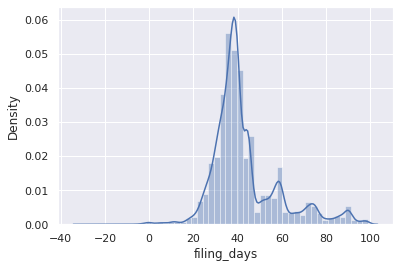

In [ ]:
show_filing_period(balance_df, 'filing_date');

In [ ]:
# Альтернативное заполнение периода подачи отчетности
def alter_filing(row):
    if type(row['filing_date']) == pd._libs.tslibs.timestamps.Timestamp:
        return row['filing_date']
    else:
        return row['date'] + datetime.timedelta(40)

In [ ]:
balance_df['alter_filing'] = balance_df.apply(alter_filing, axis=1)

In [ ]:
balance_df.head()

,Unnamed: 0,date,filing_date,currency_symbol,totalAssets,intangibleAssets,earningAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,otherCurrentLiab,commonStock,retainedEarnings,otherLiab,goodWill,otherAssets,cash,totalCurrentLiabilities,shortTermDebt,shortLongTermDebt,shortLongTermDebtTotal,otherStockholderEquity,propertyPlantEquipment,totalCurrentAssets,longTermInvestments,netTangibleAssets,shortTermInvestments,netReceivables,longTermDebt,inventory,accountsPayable,totalPermanentEquity,noncontrollingInterestInConsolidatedEntity,temporaryEquityRedeemableNoncontrollingInterests,accumulatedOtherComprehensiveIncome,additionalPaidInCapital,commonStockTotalEquity,preferredStockTotalEquity,retainedEarningsTotalEquity,treasuryStock,accumulatedAmortization,nonCurrrentAssetsOther,deferredLongTermAssetCharges,nonCurrentAssetsTotal,capitalLeaseObligations,longTermDebtTotal,nonCurrentLiabilitiesOther,nonCurrentLiabilitiesTotal,negativeGoodwill,warrants,preferredStockRedeemable,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,propertyPlantAndEquipmentGross,accumulatedDepreciation,commonStockSharesOutstanding,name,alter_filing
0,2020-09-30,2020-09-30,2020-11-12,USD,19926000.0,NaN,NaN,1764000.0,8837000.0,11089000.0,NaN,638000.0,2000.0,-215071000.0,432000.0,NaN,82000.0,9200000.0,3349000.0,664000.0,664000.0,NaN,NaN,2507000.0,16244000.0,893000.0,11089000.0,NaN,689000.0,5056000.0,4591000.0,3117000.0,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,-215071000.0,NaN,NaN,282000.0,NaN,3682000.0,203000.0,5056000.0,432000.0,5056000.0,NaN,NaN,NaN,226158000.0,19926000.0,9200000.0,NaN,NaN,21653782.0,VIVE,2020-11-12
1,2020-06-30,2020-06-30,2020-08-13,USD,20532000.0,NaN,NaN,1921000.0,9905000.0,10627000.0,NaN,1066000.0,2000.0,-211336000.0,222000.0,NaN,109000.0,8500000.0,4651000.0,5584000.0,559000.0,NaN,NaN,3120000.0,16355000.0,948000.0,10627000.0,NaN,1017000.0,5025000.0,4917000.0,1257000.0,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,-211336000.0,NaN,NaN,376000.0,NaN,4177000.0,265000.0,NaN,229000.0,5254000.0,NaN,NaN,NaN,221961000.0,20532000.0,8500000.0,NaN,NaN,15734058.0,VIVE,2020-08-13
2,2020-03-31,2020-03-31,2020-05-14,USD,21432000.0,NaN,NaN,2204000.0,8881000.0,12551000.0,NaN,703000.0,1000.0,-204221000.0,127000.0,NaN,109000.0,9042000.0,4585000.0,NaN,NaN,NaN,NaN,3305000.0,16984000.0,1034000.0,12551000.0,NaN,1279000.0,4110000.0,4459000.0,2262000.0,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,-204221000.0,NaN,NaN,441000.0,NaN,4448000.0,278000.0,4110000.0,186000.0,4296000.0,NaN,NaN,NaN,216771000.0,21432000.0,9042000.0,NaN,NaN,9000000.0,VIVE,2020-05-14
3,2019-12-31,2019-12-31,2020-03-19,USD,26977000.0,NaN,NaN,2447000.0,10456000.0,16521000.0,NaN,770000.0,1000.0,-197911000.0,35000.0,NaN,131000.0,13308000.0,6306000.0,NaN,NaN,NaN,NaN,3441000.0,22189000.0,1216000.0,16521000.0,NaN,1573000.0,3983000.0,4861000.0,1608000.0,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,-197911000.0,NaN,NaN,526000.0,NaN,4788000.0,268000.0,3983000.0,167000.0,4150000.0,NaN,NaN,NaN,214431000.0,26977000.0,13308000.0,NaN,NaN,1000000.0,VIVE,2020-03-19
4,2019-09-30,2019-09-30,NaT,USD,24149000.0,NaN,NaN,NaN,38939000.0,-14790000.0,NaN,1049000.0,NaN,-183094000.0,794000.0,NaN,131000.0,9086000.0,6248000.0,NaN,NaN,NaN,NaN,3522000.0,19084000.0,1412000.0,-14790000.0,NaN,2806000.0,31694000.0,4141000.0,1791000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,587000.0,NaN,5065000.0,257000.0,31694000.0,997000.0,32691000.0,NaN,NaN,NaN,168304000.0,NaN,9086000.0,NaN,NaN,1000000.0,VIVE,2019-11-09


In [ ]:
# Сохранение промежуточного результата
balance_df.to_csv(f'{data_dir}/balance_df.csv')

In [ ]:
# Получение датасета с частично заполненными fiiling_date
cashe_df = create_fin_dataset(files_addreses,
                              financials_common_tickers,
                              'Cash_Flow')

In [ ]:
# Приведение типов данных
cashe_df = pd.read_csv(f'{data_dir}/cashe_df.csv')
cashe_df['filing_date'] = pd.to_datetime(cashe_df['filing_date'])
cashe_df['date'] = pd.to_datetime(cashe_df['date'])
cashe_df['alter_filing'] = pd.to_datetime(cashe_df['alter_filing'])
cashe_df.head()

,Unnamed: 0,Unnamed: 0.1,date,filing_date,currency_symbol,investments,changeToLiabilities,totalCashflowsFromInvestingActivities,netBorrowings,totalCashFromFinancingActivities,changeToOperatingActivities,netIncome,changeInCash,beginPeriodCashFlow,endPeriodCashFlow,totalCashFromOperatingActivities,depreciation,otherCashflowsFromInvestingActivities,dividendsPaid,changeToInventory,changeToAccountReceivables,salePurchaseOfStock,otherCashflowsFromFinancingActivities,changeToNetincome,capitalExpenditures,changeReceivables,cashFlowsOtherOperating,exchangeRateChanges,cashAndCashEquivalentsChanges,name,alter_filing
0,0,2020-09-30,2020-09-30,2020-11-12,USD,-111000.0,-1138000.0,-111000.0,NaN,3558000.0,-392000.0,-3735000.0,700000.0,8500000.0,9200000.0,-2747000.0,314000.0,NaN,NaN,455000.0,222000.0,3565000.0,-7000.0,953000.0,111000.0,222000.0,182000.0,NaN,700000.0,VIVE,2020-11-12
1,1,2020-06-30,2020-06-30,2020-08-13,USD,-131000.0,-388000.0,-131000.0,1343000.0,4042000.0,900000.0,-7115000.0,-542000.0,9042000.0,8500000.0,-4453000.0,328000.0,NaN,NaN,-535000.0,107000.0,3025000.0,-326000.0,2867000.0,131000.0,107000.0,283000.0,NaN,-542000.0,VIVE,2020-08-13
2,2,2020-03-31,2020-03-31,2020-05-14,USD,-161000.0,-2040000.0,-161000.0,1343000.0,1631000.0,-2034000.0,-6310000.0,-4266000.0,13308000.0,9042000.0,-5736000.0,323000.0,NaN,NaN,313000.0,220000.0,1631000.0,-30000.0,1093000.0,161000.0,220000.0,665000.0,NaN,-4266000.0,VIVE,2020-05-14
3,3,2019-12-31,2019-12-31,NaT,USD,-239000.0,-183000.0,-239000.0,1343000.0,9835000.0,875000.0,-14817000.0,4222000.0,9086000.0,13308000.0,-5374000.0,359000.0,NaN,NaN,-834000.0,465000.0,16330000.0,-2102000.0,8761000.0,239000.0,NaN,NaN,NaN,NaN,VIVE,2020-02-09
4,4,2019-09-30,2019-09-30,2019-11-07,USD,-130000.0,-589000.0,-130000.0,1343000.0,6318000.0,-1057000.0,-7956000.0,-420000.0,NaN,NaN,-6608000.0,272000.0,NaN,NaN,63000.0,675000.0,6323000.0,-5000.0,1211000.0,130000.0,675000.0,-284000.0,NaN,-420000.0,VIVE,2019-11-07


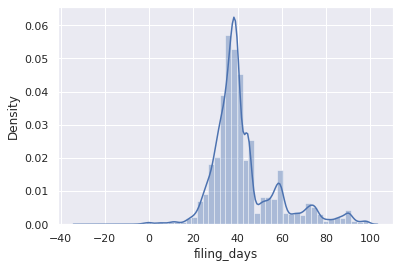

In [ ]:
show_filing_period(cashe_df);

In [ ]:
cashe_df['alter_filing'] = cashe_df.apply(alter_filing, axis=1)

In [ ]:
cashe_df.to_csv(f'{data_dir}/cashe_df.csv')

In [ ]:
# Получение датасета с частично заполненными fiiling_date
income_df = create_fin_dataset(files_addreses,
                              financials_common_tickers,
                              'Income_Statement')

In [ ]:
# Приведение типов данных
income_df = pd.read_csv(f'{data_dir}/income_df.csv')
income_df['filing_date'] = pd.to_datetime(income_df['filing_date'])
income_df['date'] = pd.to_datetime(income_df['date'])
income_df['alter_filing'] = pd.to_datetime(income_df['alter_filing'])
income_df.head()

,Unnamed: 0,Unnamed: 0.1,date,filing_date,currency_symbol,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,netIncome,sellingGeneralAdministrative,grossProfit,ebit,nonOperatingIncomeNetOther,operatingIncome,otherOperatingExpenses,interestExpense,taxProvision,interestIncome,netInterestIncome,extraordinaryItems,nonRecurring,otherItems,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,preferredStockAndOtherAdjustments,name,alter_filing
0,0,2020-09-30,2020-09-30,2020-11-12,USD,884000.0,NaN,-3680000.0,NaN,-3735000.0,2761000.0,241000.0,-3133000.0,-96000.0,-3404000.0,NaN,235000.0,NaN,NaN,-235000.0,NaN,NaN,NaN,NaN,1524000.0,3645000.0,1283000.0,-41000.0,NaN,-3680000.0,-4788000.0,1053000.0,VIVE,2020-11-12
1,1,2020-06-30,2020-06-30,2020-08-13,USD,1224000.0,NaN,-7029000.0,NaN,-7115000.0,3350000.0,-367000.0,-4640000.0,-1951000.0,-4941000.0,NaN,223000.0,NaN,NaN,-223000.0,NaN,NaN,NaN,NaN,704000.0,5645000.0,1071000.0,-1865000.0,NaN,-7029000.0,-8136000.0,1021000.0,VIVE,2020-08-13
2,2,2020-03-31,2020-03-31,2020-05-14,USD,1637000.0,NaN,-6128000.0,NaN,-6310000.0,4365000.0,175000.0,-5590000.0,-273000.0,-5827000.0,NaN,210000.0,NaN,-210000.0,-210000.0,NaN,NaN,NaN,NaN,1304000.0,7131000.0,1129000.0,-91000.0,NaN,-6128000.0,-7299000.0,989000.0,VIVE,2020-05-14
3,3,2019-12-31,2019-12-31,NaT,USD,1759000.0,NaN,-14621000.0,NaN,-14817000.0,5175000.0,-119000.0,-6722000.0,NaN,-7053000.0,NaN,835000.0,NaN,-835000.0,-835000.0,NaN,NaN,NaN,NaN,1451000.0,8504000.0,1570000.0,-6733000.0,NaN,-14621000.0,-15197000.0,NaN,VIVE,2020-02-09
4,4,2019-09-30,2019-09-30,NaT,USD,1449000.0,NaN,-7788000.0,NaN,-7956000.0,5032000.0,-47000.0,-6308000.0,NaN,-6528000.0,NaN,1209000.0,NaN,-1209000.0,-1209000.0,NaN,NaN,NaN,NaN,1052000.0,7580000.0,1099000.0,-51000.0,NaN,-7788000.0,-7956000.0,NaN,VIVE,2019-11-09


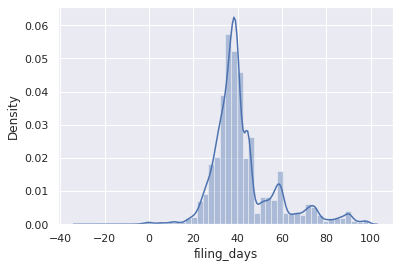

In [ ]:
show_filing_period(income_df);

In [ ]:
income_df['alter_filing'] = income_df.apply(alter_filing, axis=1)

In [ ]:
income_df.to_csv(f'{data_dir}/income_df.csv')

### Доходность

In [ ]:
# Ключ показателей доходности
tmp_dict['Earnings'].keys()

dict_keys(['History', 'Trend', 'Annual'])

In [ ]:
# Пример датафрейма c показателями доходности

earnings: pd.DataFrame = pd.DataFrame(
    tmp_dict['Earnings']
            ['History']
).T  # Транспонирование датафрейма

earnings['Name'] = ticker

earnings.head()

,reportDate,date,beforeAfterMarket,currency,epsActual,epsEstimate,epsDifference,surprisePercent,Name
2020-09-30,2020-12-31,2020-09-30,None,USD,0.3298,0.28,0.0498,17.7857,UPNRF
2020-06-30,2020-09-30,2020-06-30,None,USD,0.5042,0.03,0.4742,1580.67,UPNRF
2020-03-31,2020-06-30,2020-03-31,None,USD,0.236,0.11,0.126,114.546,UPNRF
2019-12-31,2020-03-31,2019-12-31,None,USD,0.3306,0.19,0.1406,74,UPNRF
2019-09-30,2019-12-31,2019-09-30,None,USD,0.2019,0.24,-0.0381,-15.875,UPNRF


In [ ]:
earnings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 2020-09-30 to 2010-09-30
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   reportDate         38 non-null     object
 1   date               38 non-null     object
 2   beforeAfterMarket  0 non-null      object
 3   currency           38 non-null     object
 4   epsActual          38 non-null     object
 5   epsEstimate        37 non-null     object
 6   epsDifference      37 non-null     object
 7   surprisePercent    25 non-null     object
 8   Name               38 non-null     object
dtypes: object(9)
memory usage: 3.0+ KB


In [ ]:
trend: pd.DataFrame = pd.DataFrame(
    tmp_dict['Earnings']
            ['Trend']
).T  # Транспонирование датафрейма

trend['Name'] = ticker

trend.head()

,Name


In [ ]:
annual: pd.DataFrame = pd.DataFrame(
    tmp_dict['Earnings']
            ['Annual']
).T  # Транспонирование датафрейма

annual['Name'] = ticker

annual.head()

,date,epsActual,Name
2020-09-30,2020-09-30,1.07,UPNRF
2019-12-31,2019-12-31,1.0206,UPNRF
2018-12-31,2018-12-31,0.8181,UPNRF
2017-12-31,2017-12-31,0.9828,UPNRF
2016-12-31,2016-12-31,0.6463,UPNRF


In [ ]:
annual.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 2020-09-30 to 2010-12-31
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       11 non-null     object
 1   epsActual  11 non-null     object
 2   Name       11 non-null     object
dtypes: object(3)
memory usage: 352.0+ bytes
